# Chapter 2 - Text Classification 

Can be used for many applications:
- Tagging customer feedback into categories
- Routing support tickets according to language
- Spam filtering
- Sentiment analysis
- Classifying emotional states in text

Can use *DistilBERT* for our model - comparable performance to *BERT* but with less parameters. To train on a larger *BERT* model, you could change the checkpoint weights, which is the set of weights loaded into the transformer model. 

We'll be using all 3 core libraries of HF:
- Datasets
- Tokenizers
- Transformers

### HF Datasets

The dataset we'll be using has 6 emotion options - anger, disgust, fear, joy, sadness, and surpirse. Given a tweet from the dataset, we will classify it into one of the 6 emotions. 

In [17]:
from datasets import load_dataset
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
emotions = load_dataset('emotion')

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/ZQ848WR/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

The dataset is structured similarly to a Python dictionary, with key-value pairs. We can also easily access train/val/test splits, each of which are instances of the ```dataset``` class.

The ```datasets``` library is based on *Apache Arrow*, a more memory efficient dataset storage scheme than native Python.

In [4]:
train_ds = emotions['train']
type(train_ds)

datasets.arrow_dataset.Dataset

In [5]:
len(train_ds)

16000

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_ds.column_names

['text', 'label']

In [8]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [9]:
print(train_ds[:5])
print(train_ds[:5]['text'])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}
['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### Datasets to Dataframes

Can change the type of our datasets to something else using ```set_format```

In [10]:
emotions.set_format(type='pandas')
df=emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Create coolumn to bring back our label names

In [11]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at Class Distribution

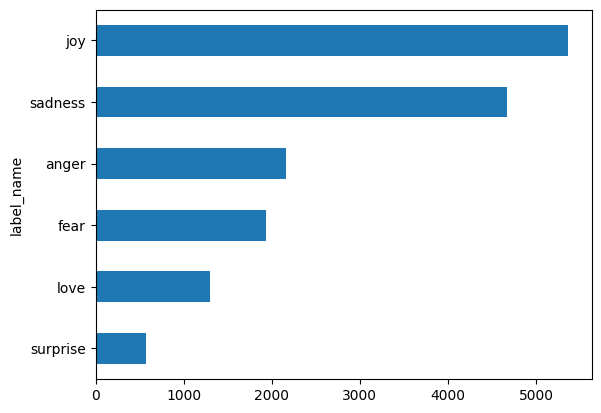

In [12]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.show()

Data is heavily imbalanced. We could:
- Randomly oversample the minority class
- Randomly undersample the majority class
- Gather more labeled data from the underrepresented class

For simplicity, we'll stick with the unbalanced classes for now.

In [13]:
# reset the format of the dataset back to Apache Arrow
emotions.reset_format()

### Character Tokenization

Easiest way to tokenize text is to feed each character individually to the model. In python, ```str``` objects are really just arrays under the hood, so character-level tokenization is easy.

In [15]:
text = 'Tokenization is a core task of NLP.'
tokenized_text = list(text)
token2idx = {
    ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))
}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'z': 17}


This maps each character to an integer. Now we can use this to transform the tokenized text into a list of integers.

In [16]:
input_ids = [
    token2idx[token] for token in tokenized_text
]
print(input_ids)

[5, 13, 11, 8, 12, 10, 17, 6, 16, 10, 13, 12, 0, 10, 15, 0, 6, 0, 7, 13, 14, 8, 0, 16, 6, 15, 11, 0, 13, 9, 0, 3, 2, 4, 1]


This approach works, but the neural network we use will almost always be too good at finding patterns in data (meaningful or not), and will interpret the numbers of an ordinal sequence. Since we don't want this kind of relationship between characters in our sequence, we'll use ont-hot encoded vectors instead. One vector per character in our sequence, with each *tensor* having a length of the total number of unique characters present ([38,20]). We'll have to convert our sequence of indicies into a Tensor first.

In [18]:
one_hot_encodings = tf.one_hot(input_ids, depth=len(token2idx))

In [ ]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor Index: {tokenized_text[0]}")
print(f"Token: {tokenized_text[0]}")